In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#read in all the names
words = open('names.txt').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [3]:
len(words)

32033

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [33]:
#build the dataset
def build_dataset(words):
    block_size = 3 # context length: how many characters do we take to predict the next one?
    X,Y = [],[]
    for w in words:
        # print(w)
        context = [0]*block_size
        for ch in w+'.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context),'-->',itos[ix])
            context.pop(0)
            context.append(ix)
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [38]:
print("training: ", n1, "words")
print("val: ", n2-n1, "words")
print("test: ", len(words)-n2, "words")

training:  25626 words
val:  3203 words
test:  3204 words


In [7]:
C = torch.randn((27,2))

In [8]:
F.one_hot(torch.tensor(5), num_classes=27).dtype

torch.int64

In [9]:
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([0.1963, 0.7793])

In [10]:
C[5]

tensor([0.1963, 0.7793])

In [11]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [12]:
W1 = torch.randn((6,100))
b1 = torch.randn(100)

In [13]:
torch.cat(torch.unbind(emb,1), 1).shape

torch.Size([228146, 6])

In [16]:
W2 = torch.randn(100,27)
b2 = torch.randn(27)

In [23]:
logits = h@W2 + b2

In [24]:
logits.shape

torch.Size([32, 27])

In [25]:
counts = logits.exp()

In [26]:
probs = counts/counts.sum(1,keepdims=True)

In [27]:
probs.shape

torch.Size([32, 27])

In [28]:
probs[0].sum()

tensor(1.)

In [30]:
Y.shapeuu

torch.Size([32])

In [33]:
#checking the current probabilities for the correct value
probs[torch.arange(32), Y]

tensor([2.5356e-14, 9.1420e-07, 9.1420e-07, 4.9083e-16, 4.5948e-09, 8.4550e-02,
        4.9714e-07, 1.9030e-06, 2.3874e-14, 1.9030e-06, 1.6222e-12, 1.6793e-10,
        1.5940e-11, 1.7764e-07, 1.5940e-11, 2.3402e-04, 1.1117e-15, 2.4558e-09,
        2.6307e-16, 2.7049e-13, 2.6748e-14, 3.9298e-10, 3.9298e-10, 2.6307e-16,
        6.7742e-11, 5.0734e-01, 8.4550e-02, 7.3692e-03, 1.0129e-07, 1.9030e-06,
        1.6222e-12, 1.6793e-10])

In [34]:
loss = -probs[torch.arange(32), Y].log().mean()

In [35]:
loss

tensor(20.3581)

### Cleaner version

In [41]:
Xtr.shape, Ytr.shape

(torch.Size([182625, 3]), torch.Size([182625]))

In [106]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,10), generator=g)
W1 = torch.randn((30,200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200,27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [52]:
sum( p.nelement() for p in parameters) #no. of parameters in total

10281

In [111]:
for p in parameters:
    p.requires_grad = True

In [112]:
lossi = []
stepi = []

In [135]:
for i in range(2000):
    #forward pass
    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,)) # the training is much faster now!
    #went from taking a couple of seconds to being almost instantaneous!
    #because we are estimating only from 32 examples, the quality of the gradient is lower, so the direction of the gradient is not as reliable
    #but we assume that the gradient is good enough that it is useful
    #much better to have an approximate gradient and take more steps
    #than it is to evaluate the exact gradient and take fewer steps.
    
    emb = C[Xtr[ix]] #(32,3,10)
    h = torch.tanh(emb.view(-1,30)@W1 + b1)
    logits = h@W2 + b2
    # counts = logits.exp()
    # probs = counts/counts.sum(1,keepdims=True)
    # loss = -probs[tor_grad = True_grad = Truech.arange(32), Y].log().mean()
    #much more efficient (used for classification)
    #no new tensors made
    #backward pass is made more efficient
    #the results are well behaved, =>
        #if one of the logits is 100, -> counts would have value inf for that logit
        #impossible to calculate prob. and also the loss
    loss = F.cross_entropy(logits,Ytr[ix]) 
    
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    #update
    lr = 0.1 if i<100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    #track stats
    lossi.append(loss.log10().item())
    stepi.append(i)
print(loss.item())

2.892313003540039


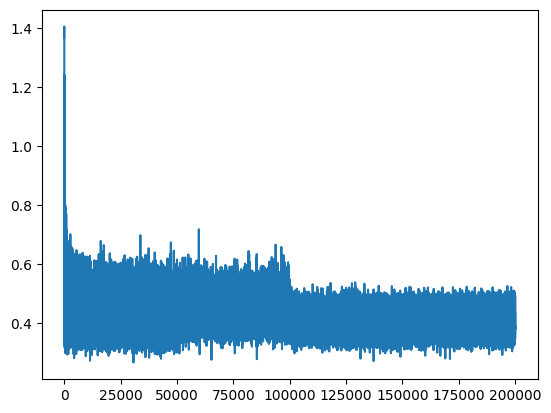

In [136]:
plt.plot(stepi, lossi)
plt.show()

In [137]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1,30)@W1 + b1)
logits = h@W2 + b2
loss = F.cross_entropy(logits,Ydev)
loss

tensor(2.8053, grad_fn=<NllLossBackward0>)

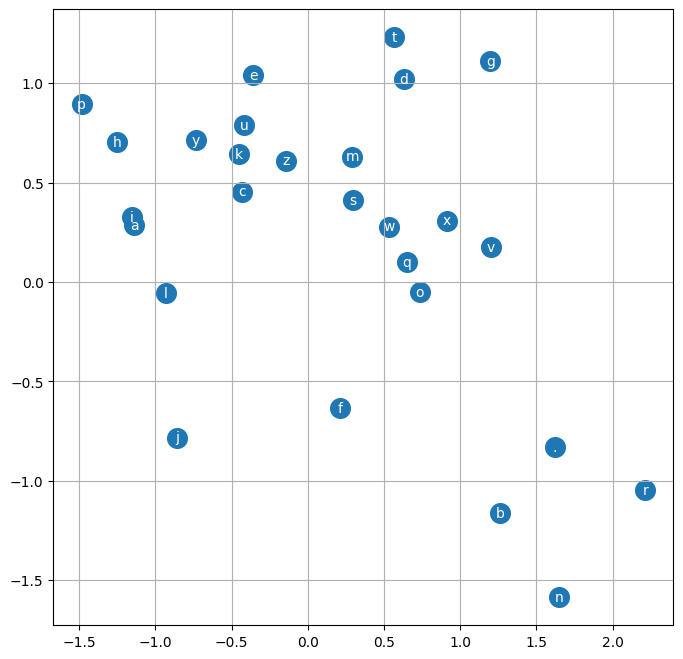

In [138]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data ,C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')

### Sample from the model

In [139]:
g = torch.Generator().manual_seed(2147483647+10)

for _ in range(20):
    out = []
    context = [0]*block_size
    while True:
        emb = C[torch.tensor([context])] #(1,block_size,d)
        h = torch.tanh(emb.view(1,-1)@W1 + b1)
        logits = h@W2 + b2
        probs = F.softmax(logits, dim=1)
        ix  = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:]+[ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

uouecekphczwwecznecbkufvkxfvkx.
ucyomtcbecbecbkufvkxfvkxfvkxekxekdekdekdekdekdfvwxekdekdekdekdfvwxecowwsexjtfvexvwioekdfvwxekdekdekdekdfvwxsccvwwsexjtyhezkdfvwxsccvsshczokuccmycbtcdecznecbkufvkxfvkx.
qqowcccqqguccicjq.
uotbduldfvwxscidmayrhjtyhccmyyrhjtrhelxekdekdekdekdbezfjt.
u.
uou.
uou.
uouecekphczwwvecctxvuczfkuocccqqcbgukdkfyzkdfvwxekdfvwxecowwsexjkogkofvwxvwioekdekdfvwxsccvwwiczkdfvwxekxekdekdekdekdfvwxmycbtcdecbkufvkx.
uouecekphvkofvwxsccvmucbaxlwzkdbevxecowwsexjtyhlkoykdfvwxowiczkkokuccvkusfvkx.
ucowwsexjtfvexvkofvwxsccvcvmucbtcwwweczokuccmyyrhjtyhjkovkofvwxekxekdekdfvwxsccvwwiczkdkfyzkdkfyzkokusfaecjtxvecccqqgmtzbecbkufvkxfvkx.
uouecekphvkofvwxsccvccsqsqhwcttwbecbkufvkx.
uoxekxekxmyzwgkczqzxjkogkofvkxfvkxfvkxfvkxfvkxfvkx.
ucyomtcbecbkufvkxvkccvwwiczkdfvvxvwcccvwwiczkdfvwxsccvwwiczkdfvwxvwioekdekdfvwxekdkfyzkogkofvkxfvkx.
q.
u.
uouecowwsexekxekdekdekdekdbevqbduldrhcbaxeqzxmtcbecbkufvkxfvkx.
uoxekdekdekdekdekdfvwxekdekdbevqbdukdkfiulnhccmyyrhjtfvexvwioekdfvwxekdekdekdfucbtcdeczn